#Welcome to our Project 4 regressor notebook!

Here we will create multiple regression tech. to predict daily high, low, wind speed and precip over Champaign IL. 

First up, clone the repository. 

In [1]:
# get our project github directory 
!git clone https://github.com/mitraarka27/ATMS-597-SP-2020-Project4-GroupG.git

Cloning into 'ATMS-597-SP-2020-Project4-GroupG'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 156 (delta 13), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (156/156), 109.13 MiB | 40.47 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [0]:
#open up the data archives (puts them in the current dir under ./bufkit)
!tar xzf ./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/daily.tar.gz
!tar xzf ./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/prof.tar.gz
!tar xzf ./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/sfc.tar.gz

The files we have are the following: 

1) YYYYMMDDHH.gfs_kcmi.buf_daily.csv

2) YYYYMMDDHH.gfs_kcmi.buf_sfc.csv

3) YYYYMMDDHH.gfs_kcmi.buf_prof.csv

 ---

The next cell defines the main class. This will do most the heavy lifting

In [75]:
import pandas as pd 
import glob 
%pylab inline 

#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'

%config InlineBackend.figure_format = 'retina'

class wxchallenge():

  """ 
  ATMS 597: Project 4 Group G. 
  Authors: Randy Chase, Arka _____, Rylan ____ 

  This is the main class for Project 4. Intended to improve numerical weather
  prediction for KCMI. Here we will just the MOS output, GFS profile data and 
  GFS surface data to do the inference. Specifically, linear regression and 
  random forest models will be used. 

  """

  def __init__(self):
    
    self.intialized = True
  
  def preprocess_daily(self):

    """
    Method to preprocess the daily forecast files (most simple model). This is
    the MOS output from the GFS. This is already fit to an extent (look up MOS
    Forecasts https://www.weather.gov/mdl/mos_gfsmos_home )

    Effectively this loads all the files into one big dataframe. Then we split
    the data into training and testing (2010-2018 and 2019). Fill with NaNs for
    missing days/forecasts

    """

    filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_daily.csv')
    filenames.sort()

    dfs = []
    for i in filenames:
      dfs.append(pd.read_csv(i))

    df_temp = pd.concat(dfs)
    df_forecast = pd.DataFrame(data={'MaxT':df_temp['TMAX'].values,'MinT':df_temp['TMIN'].values,'WMAX':df_temp['WMAX'].values,'PTOT':df_temp['RTOT'].values*25.4,},index=pd.to_datetime(pd.to_datetime(df_temp['Unnamed: 0'].values).date)+datetime.timedelta(days=1))

    #split the data into train and test 
    df_forecast_train = df_forecast.iloc[df_forecast.index.values < np.datetime64('2019-01-01')]
    df_forecast_test = df_forecast.iloc[df_forecast.index.values >= np.datetime64('2019-01-01')]

    #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_forecast_train = df_forecast_train.reindex(index=dtime_index_train)

    #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_forecast_test = df_forecast_test.reindex(index=dtime_index_test)

    self.daily_train = df_forecast_train
    self.daily_test = df_forecast_test

  def preprocess_profs(self):

    """

    Similar to the daily processing, we do this for the profiles of data out of 
    the GFS deterministic run. Right now it just makes a dataframe with all 
    profile datapoints as a feature that can be used for inference. 

    Split of train and test are the same as daily

    """

    filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_prof.csv')
    filenames.sort()



    df_list = []
    for i in filenames:
      df = pd.read_csv(i)
      index = pd.to_datetime(df['Unnamed: 0'])
      index.name = 'Time'
      df_new = make_big_df(df,index)
      df_list.append(df_new)

    df_big = pd.concat(df_list)

    #drop 100mb Dew. its all nan 
    df_big = df_big.drop(columns='DWPC_100_0')
    #fill nans with average value of the column
    df_big = df_big.apply(lambda x: x.fillna(x.mean()),axis=0)

    # split the data into train and test 
    df_prof_train = df_big.iloc[df_big.index.values < np.datetime64('2019-01-01')]
    df_prof_test = df_big.iloc[df_big.index.values >= np.datetime64('2019-01-01')]

    # valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_prof_train = df_prof_train.reindex(index=dtime_index_train)

    # #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_prof_test = df_prof_test.reindex(index=dtime_index_test)

    self.prof_train = df_prof_train
    self.prof_test = df_prof_test

  def preprocess_sfc(self):

    """

    Similar to the previous two methods. But now for the surface params. For
    example it includes the Td forecast every 3 hours for 6 - 6 UTC. 

    Train and test is the same as before. 

    """

    filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_sfc.csv')
    filenames.sort()

    df_list = []
    for i in filenames:
      df = pd.read_csv(i)
      time = list(df.keys())[1]
      dtime = pd.to_datetime(pd.to_datetime(time).date())
      names_td = ['TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',]
      names_t = ['T_surf_0','T_surf_1','T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8',]
      names_p = ['P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8',]
      names_u = ['U_surf_0','U_surf_1','U_surf_2','U_surf_3','U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8',]
      names_v = ['V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5','V_surf_6','V_surf_7','V_surf_8',]
      td = df.iloc[0].values[1:].astype('float')
      p = df.iloc[4].values[1:].astype('float')
      t = df.iloc[6].values[1:].astype('float')
      u = df.iloc[7].values[1:].astype('float')
      v = df.iloc[8].values[1:].astype('float')

      mat_all = np.hstack([td,p,t,u,v])
      mat_all = np.reshape(mat_all,[1,45])
      names_all = np.hstack([names_td,names_p,names_t,names_u,names_v])
      df_new = pd.DataFrame(data=mat_all,columns=names_all,index=[dtime])
      df_list.append(df_new)

    df_big = pd.concat(df_list)  

    # split the data into train and test 
    df_sfc_train = df_big.iloc[df_big.index.values < np.datetime64('2019-01-01')]
    df_sfc_test = df_big.iloc[df_big.index.values >= np.datetime64('2019-01-01')]

    # valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_sfc_train = df_sfc_train.reindex(index=dtime_index_train)

    # #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_sfc_test = df_sfc_test.reindex(index=dtime_index_test)

    self.sfc_train = df_sfc_train
    self.sfc_test = df_sfc_test

  def preprocess_truth(self):

    """
    Method to preprocess the observations. This is our 'truth' dataset. Or the 
    data we want to predict. 

    Train and test are the same as above. 
    """

    #load the truth data (default from Steve)
    # truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/KCMI_daily.csv',skiprows=8)
    # truth_df = truth_df.drop(columns='Unnamed: 5')
    # truth_df = truth_df.dropna(how='any')

    #reprocessed to get precip right. 
    truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/KCMI_daily_updated.csv')

    series_df = pd.DataFrame(data={'MaxT':truth_df['Max Hourly Temp (F)'].values,'MinT':truth_df['Min Hourly Temp (F)'].values,'WMAX':truth_df['Max Wind Speed (mph)'].values,'PTOT':truth_df['Total Precip (in)'].values},index=pd.to_datetime(truth_df['Date'].values))

    #split into train and test 
    df_obs_train = series_df.iloc[series_df.index.values < np.datetime64('2019-01-01')]
    df_obs_test = series_df.iloc[series_df.index.values >= np.datetime64('2019-01-01')]

    #fill missing values with np.nan
    df_obs_train = df_obs_train.where((df_obs_train.MaxT != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.MinT != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.WMAX != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.PTOT >= 0.0))
    #convert to floats and deg C 
    df_obs_train.MaxT = (df_obs_train.MaxT.astype(float) - 32)*(5/9.)
    df_obs_train.MinT = (df_obs_train.MinT.astype(float) - 32)*(5/9.)
    #convert to floats and m/s
    df_obs_train.WMAX  = (df_obs_train.WMAX.astype(float)) * 0.44704
    #convert to floats 
    df_obs_train.PTOT  = (df_obs_train.PTOT.astype(float)) 

    #fill missing values with np.nan
    df_obs_test = df_obs_test.where((df_obs_test.MaxT != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.MinT != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.WMAX != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.PTOT >= 0.0))
    #convert to floats and deg C 
    df_obs_test.MaxT = (df_obs_test.MaxT.astype(float) - 32)*(5/9.)
    df_obs_test.MinT = (df_obs_test.MinT.astype(float) - 32)*(5/9.)
    #convert to floats and m/s
    df_obs_test.WMAX  = (df_obs_test.WMAX.astype(float)) * 0.44704
    #convert to floats 
    df_obs_test.PTOT  = (df_obs_test.PTOT.astype(float)) 

    #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_obs_train = df_obs_train.reindex(index=dtime_index_train)
    #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_obs_test = df_obs_test.reindex(index=dtime_index_test)

    self.obs_train = df_obs_train
    self.obs_test = df_obs_test

  def run_simple_regressor_random_forest(self,n_estimators=None,max_depth=None,ensemble=False,n_ensembles=2):

    """
    This method preps the loaded data for use in the sklearn random forest 
    regressor. It scales the features and then gives the X,y to the regressor
    class. 

    NOTE: This uses only 1 feature as a predictor. Specifically the MOS forecast. 
    This was done to see the baseline/simplest model. 

    """
    from sklearn.preprocessing import StandardScaler
    keys = ['MaxT','MinT','WMAX','PTOT']
    regress_dict = {}
    for i in keys: 
      X_train =self.daily_train[i].values
      y_train =self.obs_train[i].values
      X_test = self.daily_test[i].values
      y_test = self.obs_test[i].values
      X_train,X_test,y_train,y_test = dropna(X_train,X_test,y_train,y_test)
      #reshape as needed 
      X_train = X_train.reshape(X_train.shape[0],1)
      X_test = X_test.reshape(X_test.shape[0],1)

      #scale it (mean 0, std 1)
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      self.X_train =  X_train_scaled
      self.X_test = X_test_scaled
      self.y_train = y_train
      self.y_test = y_test 
      regress = regressor(wxobj=self)
      if ensemble:
        regress.ensemble_random_forest(n_estimators=n_estimators,max_depth=max_depth,n_ensembles=n_ensembles)
      else:
        regress.random_forest(n_estimators=n_estimators,max_depth=max_depth)

      regress_dict[i] = regress

    self.regress_dict = regress_dict

  def run_simple_regressor_random_forest_2(self,n_estimators=None,max_depth=None,ensemble=False,n_ensembles=2):

    """
    This method preps the loaded data for use in the sklearn random forest 
    regressor. It scales the features and then gives the X,y to the regressor
    class. 

    NOTE: This uses all daily obs to do the inference. Specifically the MOS forecast. 
    This was done to see the baseline/simplest model. 

    """
    from sklearn.preprocessing import StandardScaler
    keys = ['MaxT','MinT','WMAX','PTOT']
    regress_dict = {}
    X_train = np.zeros([self.daily_train['MaxT'].values.shape[0],4])
    X_test = np.zeros([self.daily_test['MaxT'].values.shape[0],4])
    y_train = np.zeros([self.daily_train['MaxT'].values.shape[0],4])
    y_test = np.zeros([self.daily_test['MaxT'].values.shape[0],4])
    for i,ii in enumerate(keys): 
      X_train[:,i] =self.daily_train[ii].values
      y_train[:,i] =self.obs_train[ii].values
      X_test[:,i] = self.daily_test[ii].values
      y_test[:,i] = self.obs_test[ii].values

    # from IPython.core.debugger import Tracer; Tracer()() 
    X_train,X_test,y_train,y_test = dropna_2DXy(X_train,X_test,y_train,y_test)

    #scale it (mean 0, std 1)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    self.X_train =  X_train_scaled
    self.X_test = X_test_scaled
    self.y_train = y_train
    self.y_test = y_test 
    regress = regressor(wxobj=self)
    if ensemble:
      regress.ensemble_random_forest(n_estimators=n_estimators,max_depth=max_depth,n_ensembles=n_ensembles)
    else:
      regress.random_forest(n_estimators=n_estimators,max_depth=max_depth)

    self.regress_dict = regress

  def run_complex_regressor_random_forest(self,n_estimators=None,max_depth=None,ensemble=False,n_ensembles=2):

    """
    This method throws everything at the model, including the kitchen sink in 
    hopes of improving the inference. 

    Warning! this takes a bit to train because of all the features... 

    """

    from sklearn.preprocessing import StandardScaler
    keys = ['MaxT','MinT','WMAX','PTOT']
    # keys = ['MaxT']
    regress_dict = {}
    for i in keys: 

      daily = self.daily_train[i].values
      prof = self.prof_train.values
      sfc = self.sfc_train.values
      # from IPython.core.debugger import Tracer; Tracer()() 
      X_train = np.zeros([daily.shape[0],1+prof.shape[1]+sfc.shape[1]])
      X_train[:,0] = daily
      X_train[:,1:1+prof.shape[1]] = prof
      X_train[:,1+prof.shape[1]:] = sfc

      
      y_train = self.obs_train[i].values

      daily = self.daily_test[i].values
      prof = self.prof_test.values
      sfc = self.sfc_test.values
      X_test = np.zeros([daily.shape[0],1+prof.shape[1]+sfc.shape[1]])
      X_test[:,0] = daily
      X_test[:,1:1+prof.shape[1]] = prof
      X_test[:,1+prof.shape[1]:] = sfc

      y_test = self.obs_test[i].values

      X_train,X_test,y_train,y_test = dropna_2DX(X_train,X_test,y_train,y_test)

      #scale it (mean 0, std 1)
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      self.X_train =  X_train_scaled
      self.X_test = X_test_scaled
      self.y_train = y_train
      self.y_test = y_test 
      regress = regressor(wxobj=self)
      if ensemble:
        regress.ensemble_random_forest(n_estimators=n_estimators,max_depth=max_depth,n_ensembles=n_ensembles)
      else:
        regress.random_forest(n_estimators=n_estimators,max_depth=max_depth)

      regress_dict[i] = regress

    self.regress_dict_complex = regress_dict

class regressor:
  """ 

  This class is to help do the inference. It is just a generalzied form of the 
  sklearn package. It needs the wxobject that has a key X_train,X_test,y_train,
  y_test

  """
  def __init__(self,wxobj=None):
    self.initialized = True
    self.wxobj = wxobj
  def random_forest(self,n_estimators=None, max_depth=None):
    if n_estimators is None:
      n_estimators = 100

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error
    regr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)
    regr.fit(self.wxobj.X_train, self.wxobj.y_train)
    self.regr = regr 
    if len(self.wxobj.y_train.shape) > 1:
      pass
    else:
      self.score_train = regr.score(self.wxobj.X_train,self.wxobj.y_train)
      self.score_test= regr.score(self.wxobj.X_test,self.wxobj.y_test)
      self.yhat_test = regr.predict(self.wxobj.X_test)
      self.yhat_train = regr.predict(self.wxobj.X_train)
      self.y_train = self.wxobj.y_train
      self.y_test = self.wxobj.y_test

      self.rmse_test = np.sqrt(mean_squared_error(self.y_test, self.yhat_test))
      self.rmse_train = np.sqrt(mean_squared_error(self.y_train, self.yhat_train))
      self.mae_test = np.mean(np.abs(self.yhat_test-self.y_test))
      self.mae_train = np.mean(np.abs(self.yhat_train-self.y_train))

  def ensemble_random_forest(self,n_ensembles=2,n_estimators=None, max_depth=None):

    if n_estimators is None:
      n_estimators = 100

    from sklearn.ensemble import BaggingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error

    regr = BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators),n_estimators=n_ensembles,n_jobs=2)
    regr.fit(self.wxobj.X_train, self.wxobj.y_train)

    self.regr = regr 
    self.score_train = regr.score(self.wxobj.X_train,self.wxobj.y_train)
    self.score_test= regr.score(self.wxobj.X_test,self.wxobj.y_test)
    self.yhat_test = regr.predict(self.wxobj.X_test)
    self.yhat_train = regr.predict(self.wxobj.X_train)
    self.y_train = self.wxobj.y_train
    self.y_test = self.wxobj.y_test

    self.rmse_test = np.sqrt(mean_squared_error(self.y_test, self.yhat_test))
    self.rmse_train = np.sqrt(mean_squared_error(self.y_train, self.yhat_train))
    self.mae_test = np.mean(np.abs(self.yhat_test-self.y_test))
    self.mae_train = np.mean(np.abs(self.yhat_train-self.y_train))

###############################################################################
###################          Auxiliary functions         ######################
###############################################################################

def build_mat(column_data):
  mat = np.zeros([len(column_data),6])
  for i in np.arange(0,len(column_data)):
    mat[i,:] = strip_split_assign(column_data[i])
  return mat

def make_big_df(df,dtime):
  list_o_keys = list(df.keys())
  list_o_dfs = []
  mats = []
  all_names = []
  for i in list_o_keys:
    if (i == 'Unnamed: 0') or (i =='PRES'):
      continue
    names = []
    for j in np.array([925,850,700,500,250,100]):
      names.append(i + '_'+str(j))
    
    all_names.append(names)
    mats.append(build_mat(df[i]))
  
  mat_all = np.hstack(mats)
  mat_all = np.ravel(mat_all)
  mat_all = np.reshape(mat_all,[1,270])
  name_all = np.hstack(all_names)
  names_mat = create_name_matrix(name_all)
  names_mat = np.ravel(names_mat)
  df_new = pd.DataFrame(data=mat_all,columns=names_mat,index=[pd.to_datetime(dtime[0].date())])
  return df_new

def strip_split_assign(ugly_format):
  ugly_format = ugly_format.strip('[]')
  ugly_format = ugly_format.split(',')
  good_format = np.asarray(ugly_format,dtype=float)
  return good_format

def dropna(X_train,X_test,y_train,y_test):

    ind = np.isnan(X_train)
    X_train = X_train[~ind]
    y_train = y_train[~ind]
    ind = np.isnan(y_train)
    X_train = X_train[~ind]
    y_train = y_train[~ind]
    ind = np.isnan(X_test)
    X_test = X_test[~ind]
    y_test = y_test[~ind]
    ind = np.isnan(y_test)
    X_test = X_test[~ind]
    y_test = y_test[~ind]

    return X_train,X_test,y_train,y_test

def dropna_2DX(X_train,X_test,y_train,y_test):

    # from IPython.core.debugger import Tracer; Tracer()() 
    ind = np.isnan(X_train)
    ind = ind[:,0]
    X_train = X_train[~ind,:]
    y_train = y_train[~ind]
    ind = np.isnan(y_train)
    X_train = X_train[~ind,:]
    y_train = y_train[~ind]

    ind = np.isnan(X_test)
    ind = ind[:,0]
    X_test = X_test[~ind,:]
    y_test = y_test[~ind]
    ind = np.isnan(y_test)
    X_test = X_test[~ind,:]
    y_test = y_test[~ind]

    return X_train,X_test,y_train,y_test

def dropna_2DXy(X_train,X_test,y_train,y_test):

    # from IPython.core.debugger import Tracer; Tracer()() 
    ind = np.isnan(X_train)
    ind = ind[:,0]
    X_train = X_train[~ind,:]
    y_train = y_train[~ind,:]
    ind = np.isnan(y_train)
    ind = ind[:,0]
    X_train = X_train[~ind,:]
    y_train = y_train[~ind,:]

    ind = np.isnan(X_test)
    ind = ind[:,0]
    X_test = X_test[~ind,:]
    y_test = y_test[~ind,:]
    ind = np.isnan(y_test)
    ind = ind[:,0]
    X_test = X_test[~ind,:]
    y_test = y_test[~ind,:]

    return X_train,X_test,y_train,y_test

def create_name_matrix(names):
  names_mat = np.zeros([9,30],dtype=object) 

  for k in np.arange(0,9):
    filler = np.ones(30,dtype=int)*k
    filler = np.asarray(filler,dtype=str)
    res = []
    for i in list(zip(names.tolist(),filler.tolist())):
      res.append(i[0]+'_'+i[1])

    names_mat[k,:] = res    
  return names_mat

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
#let us actually run the class methods 
wx = wxchallenge()
wx.preprocess_daily()
wx.preprocess_truth()
#in this method is a way to train a random forest on all the data. Still working on its functionality 
wx.run_simple_regressor_random_forest()


In [77]:
for i in list(wx.regress_dict.keys()):
  print('RMSE on Test for ' +i + ' {}'.format(np.round(wx.regress_dict[i].rmse_test,2)))

print('\n')
for i in list(wx.regress_dict.keys()):
  print('RMSE on Train for ' +i + ' {}'.format(np.round(wx.regress_dict[i].rmse_train,2)))

RMSE on Test for MaxT 2.27
RMSE on Test for MinT 1.89
RMSE on Test for WMAX 1.87
RMSE on Test for PTOT 5.67


RMSE on Train for MaxT 2.01
RMSE on Train for MinT 1.8
RMSE on Train for WMAX 1.16
RMSE on Train for PTOT 3.42


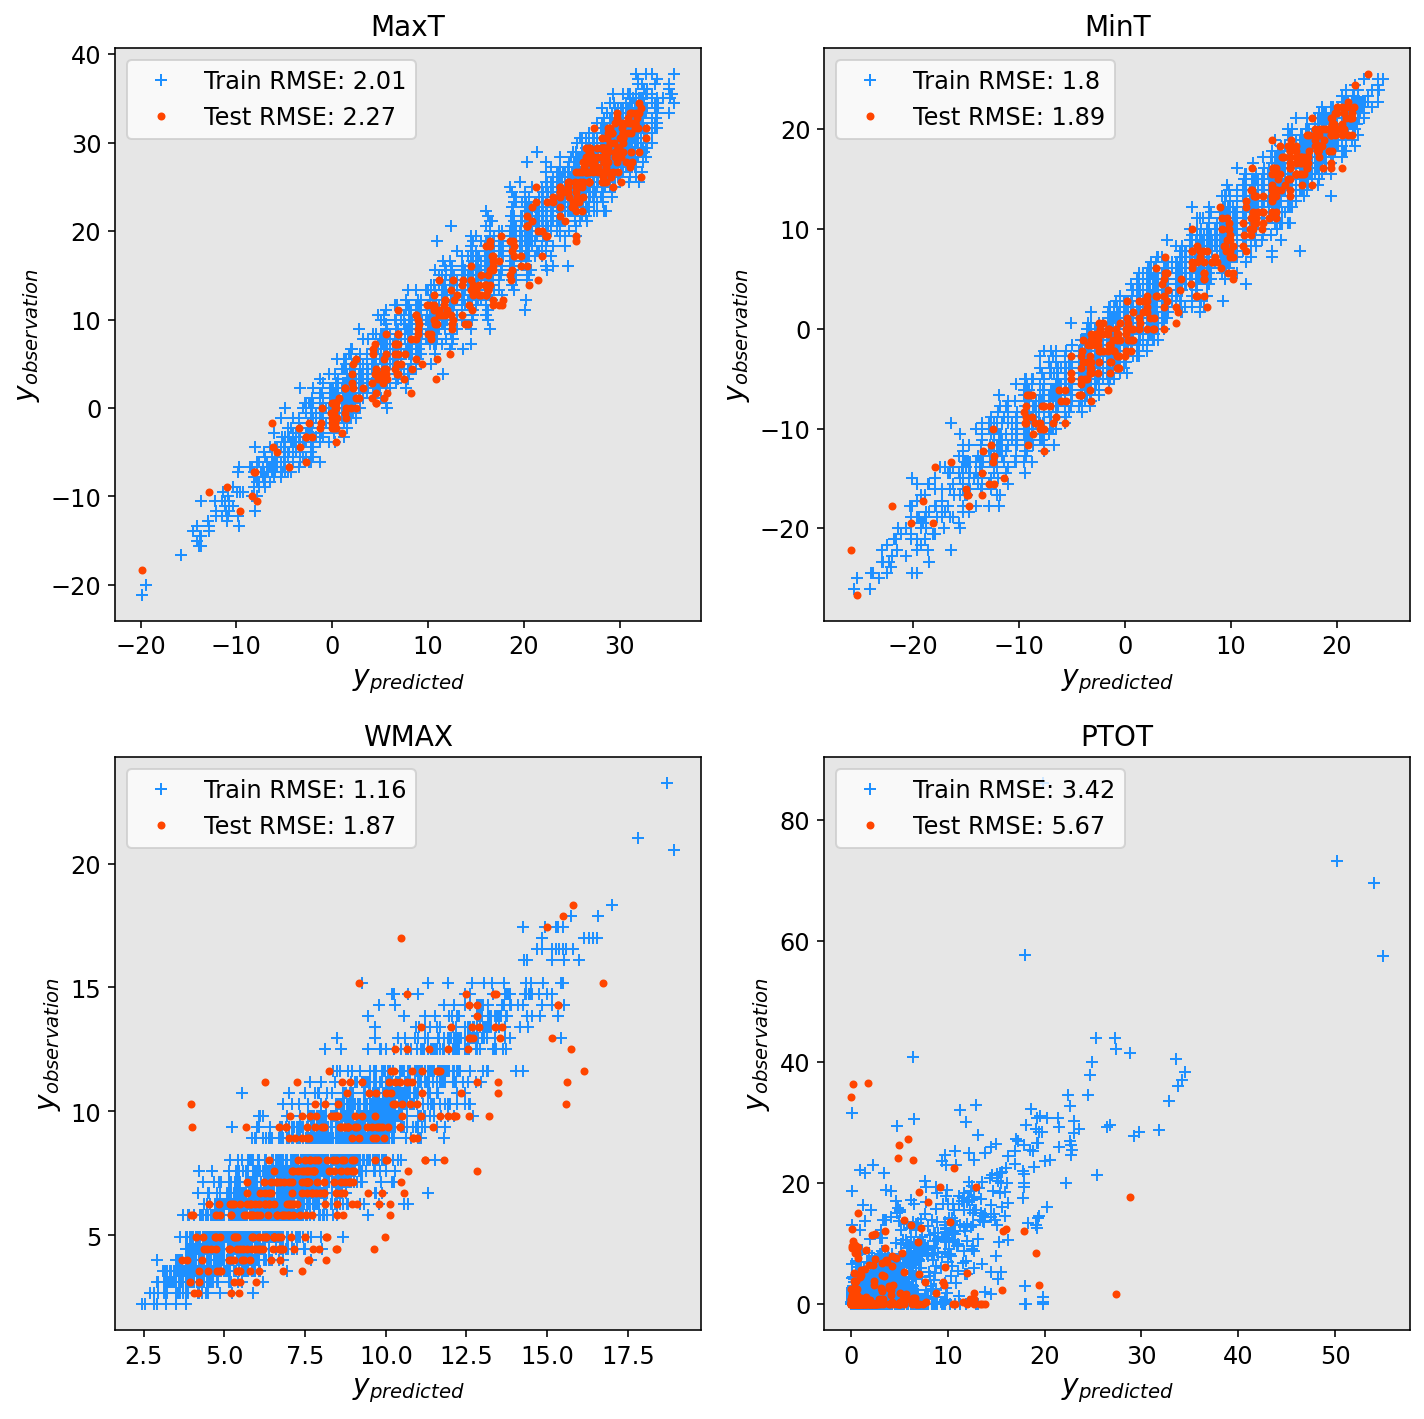

In [78]:
import copy 
fig,axes = plt.subplots(2,2,figsize=(10,10))

axes = np.ravel(axes)
for i,ii in enumerate(list(wx.regress_dict.keys())):
  ax = axes[i]
  reg_obj = copy.copy(wx.regress_dict[ii])
  ax.plot(reg_obj.yhat_train,reg_obj.y_train,'+',color='dodgerblue',label='Train RMSE: {}'.format(np.round(wx.regress_dict[ii].rmse_train,2)))
  ax.plot(reg_obj.yhat_test,reg_obj.y_test,'.',color='orangered',label='Test RMSE: {}'.format(np.round(wx.regress_dict[ii].rmse_test,2)))
  ax.set_xlabel('$y_{predicted}$')
  ax.set_ylabel('$y_{observation}$')
  ax.set_title(ii)
  ax.legend(loc=2)
  
fig.tight_layout()

### Lets step up the complexitiy here. And look to add in the profile information

In [0]:
wx.preprocess_profs()
wx.preprocess_sfc()

In [0]:
wx.run_complex_regressor_random_forest()

In [81]:
# plt.plot(wx.regress_dict_complex['WMAX'].yhat_train,wx.regress_dict_complex['WMAX'].y_train,'.')
# plt.plot(wx.regress_dict_complex['WMAX'].yhat_test,wx.regress_dict_complex['WMAX'].y_test,'.')
# wx.regress_dict_complex['WMAX'].rmse_train,wx.regress_dict_complex['WMAX'].rmse_test

for i in list(wx.regress_dict_complex.keys()):
  print('RMSE on Test for ' +i + ' {}'.format(np.round(wx.regress_dict_complex[i].rmse_test,2)))

print('\n')
for i in list(wx.regress_dict_complex.keys()):
  print('RMSE on Train for ' +i + ' {}'.format(np.round(wx.regress_dict_complex[i].rmse_train,2)))

RMSE on Test for MaxT 1.9
RMSE on Test for MinT 1.62
RMSE on Test for WMAX 1.53
RMSE on Test for PTOT 4.67


RMSE on Train for MaxT 0.74
RMSE on Train for MinT 0.62
RMSE on Train for WMAX 0.57
RMSE on Train for PTOT 1.92


These results imply that the model is overfit... 


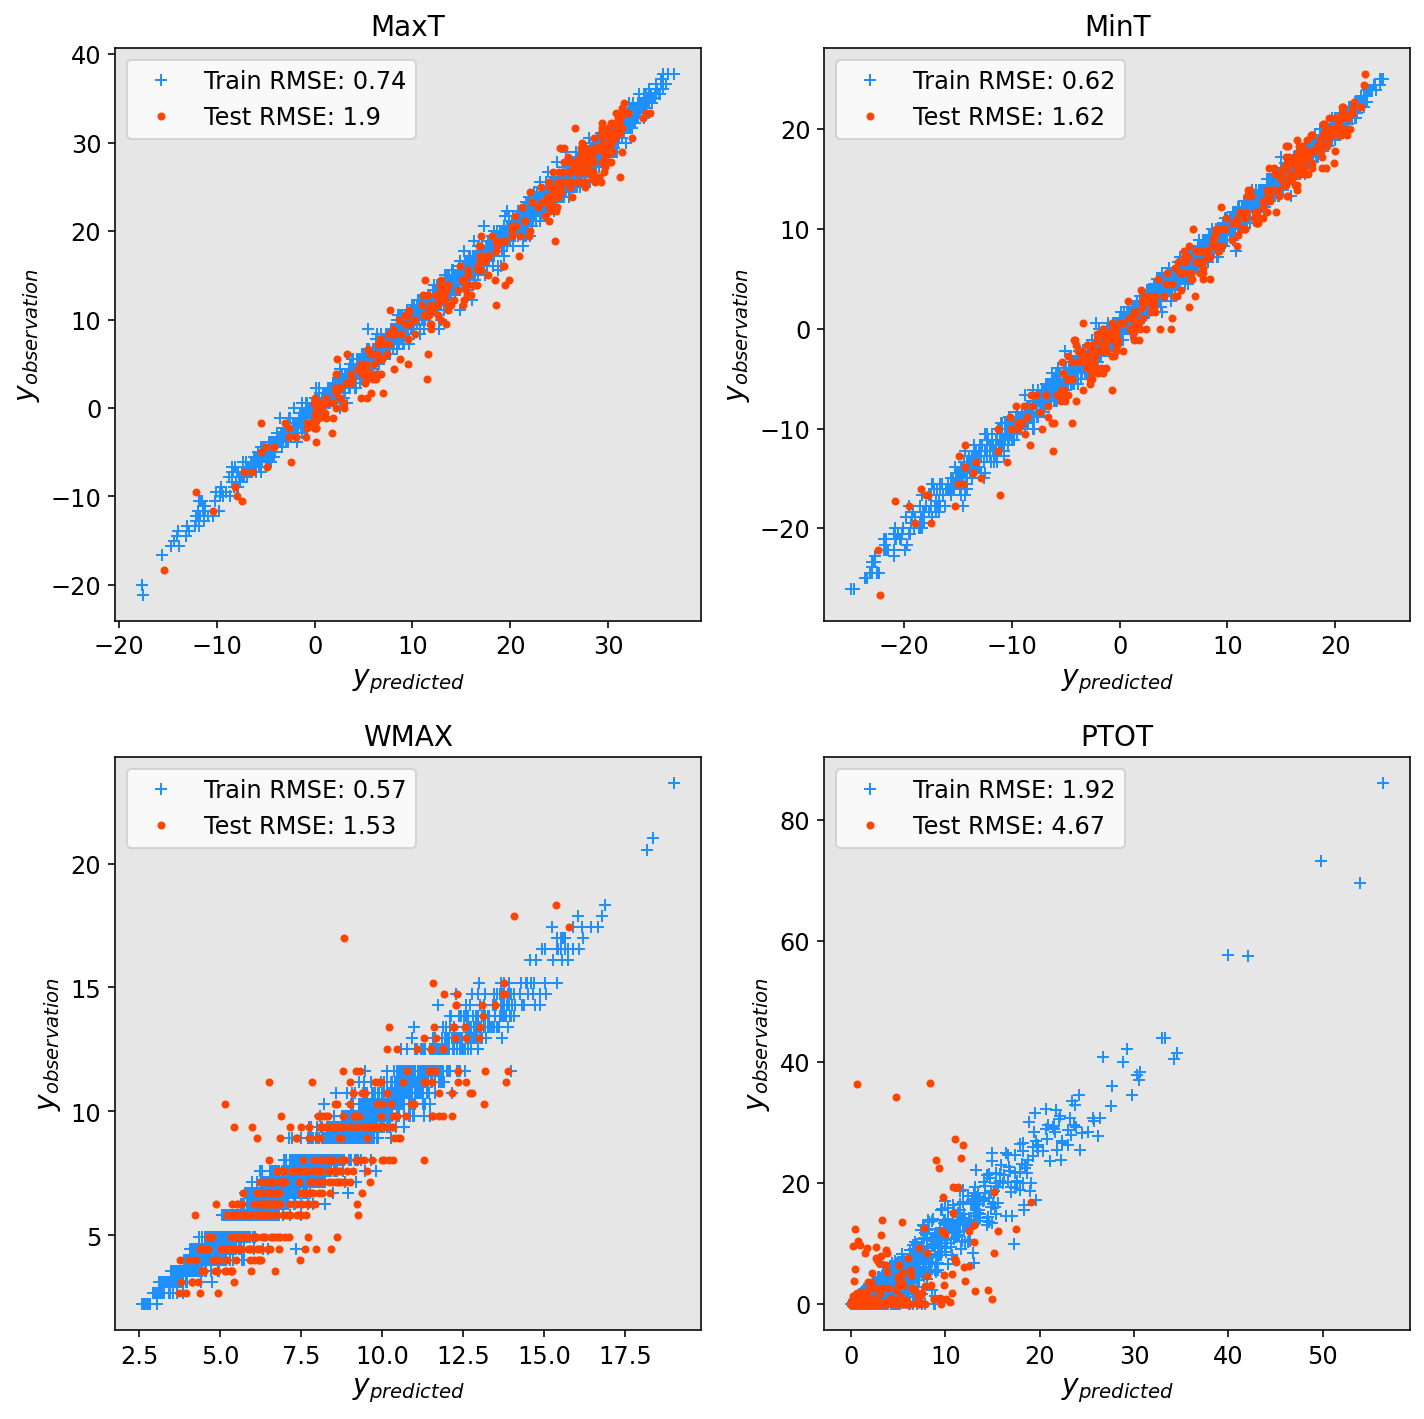

In [82]:
import copy 
fig,axes = plt.subplots(2,2,figsize=(10,10))

axes = np.ravel(axes)
for i,ii in enumerate(list(wx.regress_dict_complex.keys())):
  ax = axes[i]
  reg_obj = copy.copy(wx.regress_dict_complex[ii])
  ax.plot(reg_obj.yhat_train,reg_obj.y_train,'+',color='dodgerblue',label='Train RMSE: {}'.format(np.round(wx.regress_dict_complex[ii].rmse_train,2)))
  ax.plot(reg_obj.yhat_test,reg_obj.y_test,'.',color='orangered',label='Test RMSE: {}'.format(np.round(wx.regress_dict_complex[ii].rmse_test,2)))
  ax.set_xlabel('$y_{predicted}$')
  ax.set_ylabel('$y_{observation}$')
  ax.set_title(ii)
  ax.legend(loc=2)
  
fig.tight_layout()

# Development area 

There is alot of junk code below. Do not go here. 

### Try NN for S's and G's 

In [83]:
################################################################################
#Tensorflow package stuff
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.show()
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
################################################################################

print("GPU Available: ", tf.test.is_gpu_available())
tf.test.gpu_device_name()

2.2.0-rc2
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False


''

In [0]:
from sklearn.preprocessing import StandardScaler
# keys = ['MaxT','MinT','WMAX','PTOT']
keys = ['MaxT']
regress_dict = {}
for i in keys: 

  daily = wx.daily_train[i].values
  prof = wx.prof_train.values
  sfc = wx.sfc_train.values
  # from IPython.core.debugger import Tracer; Tracer()() 
  X_train = np.zeros([daily.shape[0],1+prof.shape[1]+sfc.shape[1]])
  X_train[:,0] = daily
  X_train[:,1:1+prof.shape[1]] = prof
  X_train[:,1+prof.shape[1]:] = sfc

  
  y_train = wx.obs_train[i].values

  daily = wx.daily_test[i].values
  prof = wx.prof_test.values
  sfc = wx.sfc_test.values
  X_test = np.zeros([daily.shape[0],1+prof.shape[1]+sfc.shape[1]])
  X_test[:,0] = daily
  X_test[:,1:1+prof.shape[1]] = prof
  X_test[:,1+prof.shape[1]:] = sfc

  y_test = wx.obs_test[i].values

  X_train,X_test,y_train,y_test = dropna_2DX(X_train,X_test,y_train,y_test)

  #scale it (mean 0, std 1)
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

In [133]:
#build model
model = keras.Sequential([
    keras.layers.Dense(100, activation=tf.nn.relu,input_shape=([wx.X_train.shape[1]])),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

lr = 0.001
# optimizer = tf.keras.optimizers.Adam(lr=lr)
optimizer = tf.keras.optimizers.RMSprop(lr=lr)
# def scheduler(epoch):
#   if (np.mod(epoch,5)==0) and (epoch > 0):
#     return lr * 0.999999**(epoch/1)
#   else:
#     return lr

# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
# model.compile(loss=tf.keras.losses.Huber(delta=1.),
#                 optimizer=optimizer,
#                 metrics=['mean_absolute_error','mean_squared_error'])
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=['mean_absolute_error','mean_squared_error'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 100)               31600     
_________________________________________________________________
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 101       
Total params: 41,801
Trainable params: 41,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
# with tf.device(''):
X_train_sub = np.copy(X_train_scaled)
X_test_sub = np.copy(X_test_scaled)

history = model.fit(X_train_sub, y_train, epochs=100,validation_data=(X_test_sub, y_test),batch_size=128,shuffle=True,verbose=0,callbacks=[callback])

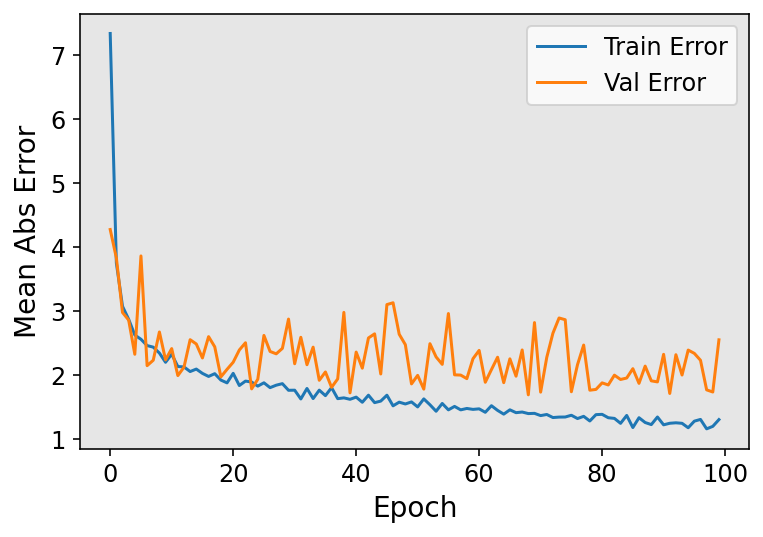

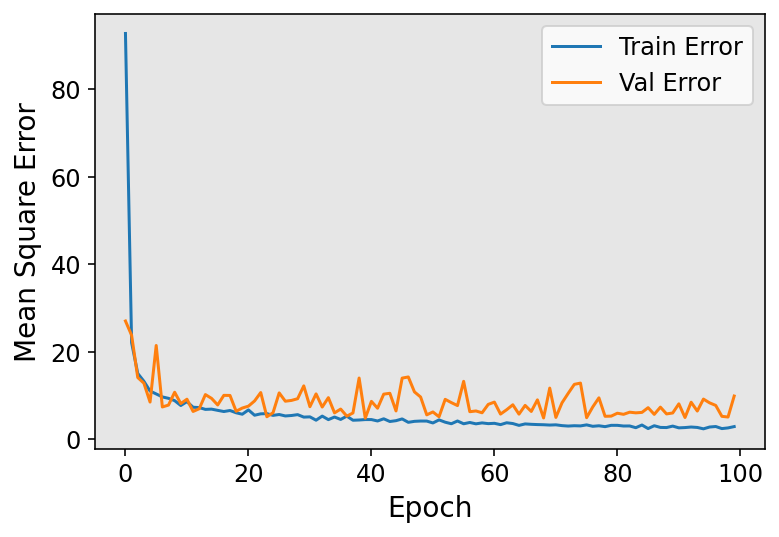

In [135]:
plot_history(history)

12.02009303732794

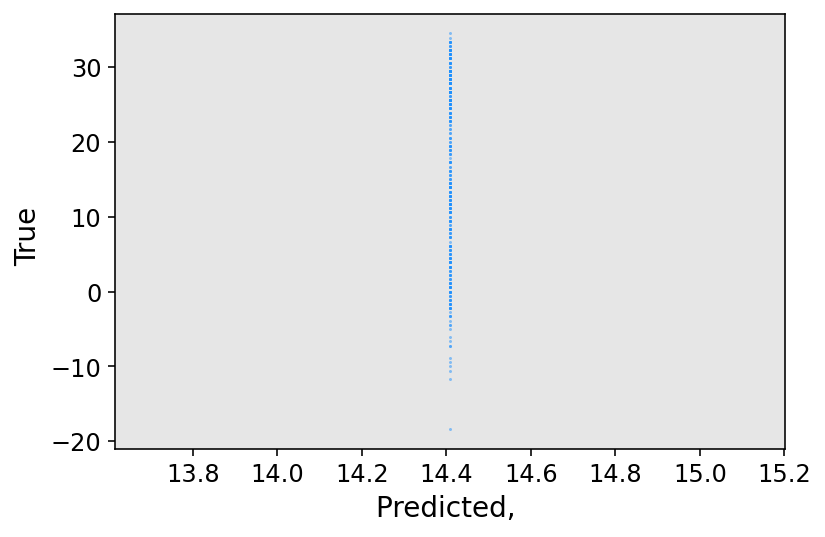

In [132]:
yhat = model.predict(X_test_sub)
plt.plot(yhat,y_test,'o',alpha=0.5,ms=0.5,color='dodgerblue')
# plt.plot([0,2],[0,2],'-k')
# plt.xlim(0.05,10)
# plt.ylim(0.05,10)
plt.gca().set_facecolor([0.9,0.9,0.9])
plt.xlabel(r'Predicted, ',fontsize=14)
plt.ylabel(r"True ",fontsize=14)
plt.gca().tick_params(labelsize=12)

np.sqrt(mean_squared_error(y_test, yhat))


In [0]:

def preprocess_sfc(self):
  filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_sfc.csv')
  filenames.sort()

  df_list = []
  for i in filenames:
    df = pd.read_csv(i)
    time = list(df.keys())[1]
    dtime = pd.to_datetime(pd.to_datetime(time).date())
    names_td = ['TD_surf_0','TD_surf_1','TD_surf_2','TD_surf_3','TD_surf_4','TD_surf_5','TD_surf_6','TD_surf_7','TD_surf_8',]
    names_t = ['T_surf_0','T_surf_1','T_surf_2','T_surf_3','T_surf_4','T_surf_5','T_surf_6','T_surf_7','T_surf_8',]
    names_p = ['P_surf_0','P_surf_1','P_surf_2','P_surf_3','P_surf_4','P_surf_5','P_surf_6','P_surf_7','P_surf_8',]
    names_u = ['U_surf_0','U_surf_1','U_surf_2','U_surf_3','U_surf_4','U_surf_5','U_surf_6','U_surf_7','U_surf_8',]
    names_v = ['V_surf_0','V_surf_1','V_surf_2','V_surf_3','V_surf_4','V_surf_5','V_surf_6','V_surf_7','V_surf_8',]
    td = df.iloc[0].values[1:].astype('float')
    p = df.iloc[4].values[1:].astype('float')
    t = df.iloc[6].values[1:].astype('float')
    u = df.iloc[7].values[1:].astype('float')
    v = df.iloc[8].values[1:].astype('float')

    mat_all = np.hstack([td,p,t,u,v])
    mat_all = np.reshape(mat_all,[1,45])
    names_all = np.hstack([names_td,names_p,names_t,names_u,names_v])
    df_new = pd.DataFrame(data=mat_all,columns=names_all,index=[dtime])
    df_list.append(df_new)

  df_big = pd.concat(df_list)  

  # split the data into train and test 
  df_sfc_train = df_big.iloc[df_big.index.values < np.datetime64('2019-01-01')]
  df_sfc_test = df_big.iloc[df_big.index.values >= np.datetime64('2019-01-01')]

  # valid training range
  dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
  df_sfc_train = df_sfc_train.reindex(index=dtime_index_train)

  # #valid testing range 
  dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
  df_sfc_test = df_sfc_test.reindex(index=dtime_index_test)

  self.prof_train = df_prof_train
  self.prof_test = df_prof_test

In [0]:
df_sfc_train.shape

(3286, 45)

In [0]:
regr = RandomForestRegressor(max_depth=None, n_estimators=100)
regr.fit(X_train_pca, y_train)


regr = regr 
score_train = regr.score(X_train_pca,y_train)
score_test= regr.score(X_test_pca,y_test)
yhat_test = regr.predict(X_test_pca)
yhat_train = regr.predict(X_train_pca)
# y_train = self.wxobj.y_train
# y_test = self.wxobj.y_test

rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
mae_test = np.mean(np.abs(yhat_test-y_test))
mae_train = np.mean(np.abs(yhat_train-y_train))

print('depth:{}, estimators:{}, test:{}, train:{}'.format(i,j,rmse_test,rmse_train))
# regr.max_depth

depth:MaxT, estimators:100, test:3.6177463586378193, train:1.3929811886605088


In [0]:
import xarray as xr 
def strip_split_assign(ugly_format):
  ugly_format = ugly_format.strip('[]')
  ugly_format = ugly_format.split(',')
  good_format = np.asarray(ugly_format,dtype=float)
  return good_format

def make_ds(df,dtime):
  list_o_keys = list(df.keys())
  list_o_da = []
  for i in list_o_keys:
    if i == 'Unnamed: 0':
      continue
    da = xr.DataArray(build_mat(df[i]),dims={'time':dtime.values,
                                               'pressure': np.array([925,850,700,500,250,100])},coords={'time':dtime.values,
                                               'pressure': np.array([925,850,700,500,250,100])},name=i)
    list_o_da.append(da)

  ds = xr.merge(list_o_da)
  return ds

def make_big_df(df,dtime):
  list_o_keys = list(df.keys())
  list_o_dfs = []
  mats = []
  all_names = []
  for i in list_o_keys:
    if (i == 'Unnamed: 0') or (i =='PRES'):
      continue
    names = []
    for j in np.array([925,850,700,500,250,100]):
      names.append(i + '_'+str(j))
    
    all_names.append(names)
    mats.append(build_mat(df[i]))
  
  mat_all = np.hstack(mats)
  mat_all = np.ravel(mat_all)
  mat_all = np.reshape(mat_all,[1,270])
  name_all = np.hstack(all_names)
  names_mat = create_name_matrix(name_all)
  names_mat = np.ravel(names_mat)
  df_new = pd.DataFrame(data=mat_all,columns=names_mat,index=[pd.to_datetime(dtime[0].date())])
  return df_new

def build_mat(column_data):
  mat = np.zeros([len(column_data),6])
  for i in np.arange(0,len(column_data)):
    mat[i,:] = strip_split_assign(column_data[i])
  return mat

def concat_all_prof_files(filenames):
  list_of_ds = []
  for i in filenames:
    df = pd.read_csv(i)
    index = pd.to_datetime(df['Unnamed: 0'])
    ds = make_ds(df,index)

    list_of_ds.append(ds)
  
  ds = xr.concat(list_of_ds,dim='time')

  return ds 
# ds = concat_all_prof_files(filenames[0:1])

def create_name_matrix(names):
  names_mat = np.zeros([9,30],dtype=object) 

  for k in np.arange(0,9):
    filler = np.ones(30,dtype=int)*k
    filler = np.asarray(filler,dtype=str)
    res = []
    for i in list(zip(names.tolist(),filler.tolist())):
      res.append(i[0]+'_'+i[1])

    names_mat[k,:] = res    
  return names_mat



df_list = []
for i in filenames:
  df = pd.read_csv(i)
  index = pd.to_datetime(df['Unnamed: 0'])
  index.name = 'Time'
  df_new = make_big_df(df,index)
  df_list.append(df_new)

df_big = pd.concat(df_list)


# # split the data into train and test 
# df_prof_train = df_big.iloc[df_big.index.values < np.datetime64('2019-01-01')]
# df_prof_test = df_big.iloc[df_big.index.values >= np.datetime64('2019-01-01')]

# # valid training range
# dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
# df_prof_train = df_prof_train.reindex(index=dtime_index_train)

# # #valid testing range 
# dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
# df_prof_test = df_prof_test.reindex(index=dtime_index_test)

,DWPC_925_0,DWPC_850_0,DWPC_700_0,DWPC_500_0,DWPC_250_0,DWPC_100_0,HGHT_925_0,HGHT_850_0,HGHT_700_0,HGHT_500_0,HGHT_250_0,HGHT_100_0,TMPC_925_0,TMPC_850_0,TMPC_700_0,TMPC_500_0,TMPC_250_0,TMPC_100_0,UWND_925_0,UWND_850_0,UWND_700_0,UWND_500_0,UWND_250_0,UWND_100_0,VWND_925_0,VWND_850_0,VWND_700_0,VWND_500_0,VWND_250_0,VWND_100_0,DWPC_925_1,DWPC_850_1,DWPC_700_1,DWPC_500_1,DWPC_250_1,DWPC_100_1,HGHT_925_1,HGHT_850_1,HGHT_700_1,HGHT_500_1,...,UWND_700_7,UWND_500_7,UWND_250_7,UWND_100_7,VWND_925_7,VWND_850_7,VWND_700_7,VWND_500_7,VWND_250_7,VWND_100_7,DWPC_925_8,DWPC_850_8,DWPC_700_8,DWPC_500_8,DWPC_250_8,DWPC_100_8,HGHT_925_8,HGHT_850_8,HGHT_700_8,HGHT_500_8,HGHT_250_8,HGHT_100_8,TMPC_925_8,TMPC_850_8,TMPC_700_8,TMPC_500_8,TMPC_250_8,TMPC_100_8,UWND_925_8,UWND_850_8,UWND_700_8,UWND_500_8,UWND_250_8,UWND_100_8,VWND_925_8,VWND_850_8,VWND_700_8,VWND_500_8,VWND_250_8,VWND_100_8
2010-01-02,-17.885417,-22.151502,-38.936782,-58.098371,-71.388427,NaN,822.269306,1460.103333,2904.463312,5334.628820,10036.347191,15964.786,-16.249583,-16.522911,-21.191230,-31.397079,-52.297079,-55.84,10.566531,4.214706,17.668810,51.474499,80.039564,58.267854,-21.603492,-18.300224,-29.544206,-49.513732,-58.904689,-24.295145,-19.453125,-24.938868,-42.044969,-58.101408,-71.386866,NaN,822.054375,1459.778585,2907.494277,5354.199859,...,24.840823,46.670103,75.194994,44.492985,-14.134741,-19.895924,-38.242046,-44.745111,-25.027749,-5.631817,-25.627500,-33.058302,-45.495597,-38.256713,-66.478358,NaN,820.549167,1458.304906,2932.431478,5437.138371,10082.642127,15963.980000,-16.143333,-15.216604,-13.564717,-25.654944,-57.889851,-55.840000,-1.975476,3.007115,20.205429,44.567533,71.176293,45.331369,-8.494141,-13.486745,-32.156633,-38.970599,-19.831462,-9.242547
2010-01-03,-27.400208,-34.565258,-44.304214,-36.057725,-65.850149,NaN,830.313542,1472.654038,2955.178931,5455.344944,10102.468806,15980.104,-15.187083,-12.592394,-13.789874,-26.483315,-57.160000,-56.70,0.651006,10.723922,25.509357,44.849646,79.354655,47.570158,-14.970435,-23.241144,-25.094933,-28.605803,-17.226121,-3.999594,-25.322897,-36.407736,-54.588994,-34.992697,-64.108060,NaN,830.036207,1470.556698,2950.236509,5447.958539,...,4.517203,29.760959,23.705177,28.452585,-12.201104,-10.996784,-17.058931,-33.823197,-17.633164,-7.692015,-25.736667,-26.004340,-33.074543,-50.040507,-71.385768,NaN,814.494186,1462.346321,2940.111735,5396.740789,10038.357228,15942.590000,-12.670853,-11.294434,-16.238864,-30.925915,-53.851386,-53.760000,3.499557,3.498790,5.501196,26.546257,25.624138,27.317706,-13.226089,-11.597696,-17.739194,-31.636565,-13.489874,-5.806558
2010-01-04,-19.079167,-19.882547,-29.703912,-50.085268,-70.333820,NaN,821.973958,1471.144151,2946.764795,5400.031324,10029.457079,15932.864,-11.653750,-11.170377,-16.845804,-31.045634,-53.938652,-53.32,4.671241,5.035311,5.512431,22.150540,25.903228,27.583876,-14.555032,-15.435497,-18.429099,-27.279792,-12.080111,-5.114361,-19.597862,-22.642254,-28.828233,-53.933859,-70.317239,NaN,817.902759,1465.861831,2940.092429,5389.715070,...,3.863955,5.416036,12.217397,28.953472,-20.325887,-17.921532,-24.897778,-27.120477,-4.306438,-7.960981,-15.979302,-18.005118,-20.012286,-32.362712,-65.800562,NaN,795.587674,1443.041801,2924.047429,5399.847797,10021.178652,15895.138000,-13.232093,-11.312607,-15.205714,-29.338814,-58.225169,-54.880000,4.083795,3.717828,5.985816,6.708492,12.218160,30.221989,-16.103266,-16.601062,-24.111237,-28.190929,-3.098121,-11.192647
2010-01-05,-16.815194,-20.669009,-19.775601,-33.001780,-66.479213,NaN,799.723643,1448.556651,2929.161741,5402.594322,10009.157303,15898.674,-12.781705,-10.760000,-15.817595,-29.455198,-56.242022,-54.56,6.633821,6.511088,5.757655,2.564155,9.797710,27.729411,-17.416933,-19.439059,-25.696594,-23.075714,-1.151707,-7.809010,-15.397907,-17.143396,-20.731772,-33.661130,-65.797368,NaN,792.987442,1441.856604,2926.520127,5404.636045,...,11.689561,17.044808,33.106759,31.852935,-17.040128,-18.849077,-16.146781,-18.720673,-34.991843,-17.026463,

In [0]:
#drop 100mb Dew. its all nan 
df_big = df_big.drop(columns='DWPC_100_0')
#fill nans with average value of the column
df_big = df_big.apply(lambda x: x.fillna(x.mean()),axis=0)

(array([], dtype=int64), array([], dtype=int64))

In [0]:
ds_oneday = ds.where(ds.time >= np.datetime64('2010-01-02T06:00:00'))
# ds_oneday = ds_oneday.where(ds_oneday.time <= np.datetime64('2010-01-03T06:00:00'))
# ds_oneday = ds_oneday.dropna(dim='time',how='all')
# ds_oneday.time
# ds.shape
#there are 9 profiles for each forecast time 
ind = np.arange(0,len(ds.time),9)
ds.time.values[ind[0]:ind[1]]
# len(ind),wx.daily_train.shape
ds_train = ds.where(ds.time < np.datetime64('2019-01-01'))
# ds_train = ds_train.dropna(dim='time',how='all')
ds_test = ds.where(ds.time >= np.datetime64('2019-01-01'))
# ds_test = ds_test.dropna(dim='time',how='all')

ind = np.arange(0,len(ds_train.time),9)
# len(ind),wx.daily_train.shape
ind_cut = np.where(ds.time.values == np.datetime64('2019-01-01T06:00:00'))[0]
# ind_cut[-1]
ds
# ds.time.values[:ind_cut[-1]]
# dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
# dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')

<xarray.Dataset>
Dimensions:   (pressure: 6, time: 32805)
Coordinates:
  * pressure  (pressure) int64 925 850 700 500 250 100
  * time      (time) datetime64[ns] 2010-01-02T06:00:00 ... 2020-02-02T06:00:00
Data variables:
    DWPC      (time, pressure) float64 -17.89 -22.15 -38.94 ... -60.07 nan
    HGHT      (time, pressure) float64 822.3 1.46e+03 ... 1.039e+04 1.61e+04
    PRES      (time, pressure) float64 925.0 850.0 700.0 ... 500.0 250.0 100.0
    TMPC      (time, pressure) float64 -16.25 -16.52 -21.19 ... -54.48 -58.86
    UWND      (time, pressure) float64 10.57 4.215 17.67 ... 46.55 42.32 35.43
    VWND      (time, pressure) float64 -21.6 -18.3 -29.54 ... -47.88 -75.1 -7.19

we see that for Jan 1 2010, the forecast for 2010-01-02 was:

High = -11.26 degC

Low = -16.46 degC

WMAX = 7.32 m/s

Precip = 0.05 inches

Let's make the dataframe for the forecasts

In [0]:
# Python code to demonstrate converting  
# string representation of list to list 
# using json.loads() 
import json 
  
# initializing string representation of a list 
ini_list = "[1, 2, 3, 4, 5]"
  
# printing intialized string of list and its type 
print ("initial string", ini_list) 
print (type(ini_list)) 
  
# Converting string to list 
res = json.loads(ini_list) 
  
# printing final result and its type 
print ("final list", res) 
print (type(res)) 

initial string [1, 2, 3, 4, 5]
<class 'str'>
final list [1, 2, 3, 4, 5]
<class 'list'>


In [0]:
#load the truth data
truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/KCMI_daily.csv',skiprows=8)
truth_df = truth_df.drop(columns='Unnamed: 5')
truth_df = truth_df.dropna(how='any')
truth_df.head()

,Date,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in)
0,2010-01-01,12,2,15,M
1,2010-01-02,6,-5,15,0.00
2,2010-01-03,10,-6,11,0.00
3,2010-01-04,11,-2,20,0.00
4,2010-01-05,10,-1,16,M


For now, lets just look at temperature 

In [0]:
truth_df = truth_df.drop(columns='Total Precip (in)')

In [0]:
series_df = pd.DataFrame(data={'MaxT':truth_df['Max Hourly Temp (F)'].values,'MinT':truth_df['Min Hourly Temp (F)'].values,},index=pd.to_datetime(truth_df['Date'].values))

#split into train and test 
df_obs_train = series_df.iloc[series_df.index.values < np.datetime64('2019-01-01')]
df_obs_test = series_df.iloc[series_df.index.values >= np.datetime64('2019-01-01')]

In [0]:
#fill missing values with np.nan
df_obs_train = df_obs_train.where((df_obs_train.MaxT != 'M'))
df_obs_train = df_obs_train.where((df_obs_train.MinT != 'M'))
#convert to floats and deg C 
df_obs_train.MaxT = (df_obs_train.MaxT.astype(float) - 32)*(5/9.)
df_obs_train.MinT = (df_obs_train.MinT.astype(float) - 32)*(5/9.)

#fill missing values with np.nan
df_obs_test = df_obs_test.where((df_obs_test.MaxT != 'M'))
df_obs_test = df_obs_test.where((df_obs_test.MinT != 'M'))
#convert to floats and deg C 
df_obs_test.MaxT = (df_obs_test.MaxT.astype(float) - 32)*(5/9.)
df_obs_test.MinT = (df_obs_test.MinT.astype(float) - 32)*(5/9.)

df_obs_train.head()

,MaxT,MinT
2010-01-01,-11.111111,-16.666667
2010-01-02,-14.444444,-20.555556
2010-01-03,-12.222222,-21.111111
2010-01-04,-11.666667,-18.888889
2010-01-05,-12.222222,-18.333333


In [0]:
#valid training range
dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
#valid testing range 
dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')

df_forecast_train = df_forecast_train.reindex(index=dtime_index_train)
df_obs_train = df_obs_train.reindex(index=dtime_index_train)

df_forecast_test = df_forecast_test.reindex(index=dtime_index_test)
df_obs_test = df_obs_test.reindex(index=dtime_index_test)

Ok. now we can do SKLEARN things

In [0]:
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

X_train = df_forecast_train.MaxT.values
y_train = df_obs_train.MaxT.values

X_test = df_forecast_test.MaxT.values
y_test = df_obs_test.MaxT.values

ind = np.isnan(X_train)
X_train = X_train[~ind]
y_train = y_train[~ind]

ind = np.isnan(y_train)
X_train = X_train[~ind]
y_train = y_train[~ind]

ind = np.isnan(X_test)
X_test = X_test[~ind]
y_test = y_test[~ind]

ind = np.isnan(y_test)
X_test = X_test[~ind]
y_test = y_test[~ind]

X_train = X_train.reshape(X_train.shape[0],1)
X_test = X_test.reshape(X_test.shape[0],1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


reg = LinearRegression().fit(X_train_scaled, y_train)
y_hat = reg.predict(X_test_scaled)

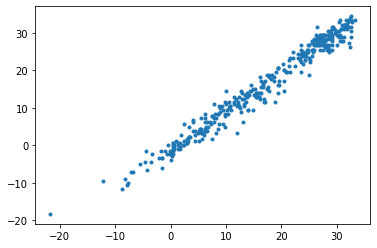

In [0]:
plt.plot(y_hat,y_test,'.')

In [0]:
reg.score(X_test_scaled,y_test)

0.9675801863384572

In [0]:
np.mean(np.abs(y_hat - y_test))

1.6368555736721184

In [0]:
class wxchallenge():

  def __init__(self):
    self.intialized = True
  
  def preprocess_daily(self):

    """
    Method to preprocess the daily forecast files (most simple model)
    """

    filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_daily.csv')
    filenames.sort()

    dfs = []
    for i in filenames:
      dfs.append(pd.read_csv(i))

    df_temp = pd.concat(dfs)
    df_forecast = pd.DataFrame(data={'MaxT':df_temp['TMAX'].values,'MinT':df_temp['TMIN'].values,'WMAX':df_temp['WMAX'].values,'PTOT':df_temp['PTOT'].values,},index=pd.to_datetime(pd.to_datetime(df_temp['Unnamed: 0'].values).date)+datetime.timedelta(days=1))

    #split the data into train and test 
    df_forecast_train = df_forecast.iloc[df_forecast.index.values < np.datetime64('2019-01-01')]
    df_forecast_test = df_forecast.iloc[df_forecast.index.values >= np.datetime64('2019-01-01')]

    #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_forecast_train = df_forecast_train.reindex(index=dtime_index_train)

    #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_forecast_test = df_forecast_test.reindex(index=dtime_index_test)

    self.daily_train = df_forecast_train
    self.daily_test = df_forecast_test

  def preprocess_truth(self):

    #load the truth data
    truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/KCMI_daily.csv',skiprows=8)
    truth_df = truth_df.drop(columns='Unnamed: 5')
    truth_df = truth_df.dropna(how='any')
    truth_df.head()


    truth_df = truth_df.drop(columns='Total Precip (in)')

    series_df = pd.DataFrame(data={'MaxT':truth_df['Max Hourly Temp (F)'].values,'MinT':truth_df['Min Hourly Temp (F)'].values,'WMAX':truth_df['Max Wind Speed (mph)'].values},index=pd.to_datetime(truth_df['Date'].values))

    #split into train and test 
    df_obs_train = series_df.iloc[series_df.index.values < np.datetime64('2019-01-01')]
    df_obs_test = series_df.iloc[series_df.index.values >= np.datetime64('2019-01-01')]

    #fill missing values with np.nan
    df_obs_train = df_obs_train.where((df_obs_train.MaxT != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.MinT != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.WMAX != 'M'))
    #convert to floats and deg C 
    df_obs_train.MaxT = (df_obs_train.MaxT.astype(float) - 32)*(5/9.)
    df_obs_train.MinT = (df_obs_train.MinT.astype(float) - 32)*(5/9.)
    #convert to floats and m/s
    df_obs_train.WMAX  = (df_obs_train.WMAX.astype(float)) * 0.44704

    #fill missing values with np.nan
    df_obs_test = df_obs_test.where((df_obs_test.MaxT != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.MinT != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.WMAX != 'M'))
    #convert to floats and deg C 
    df_obs_test.MaxT = (df_obs_test.MaxT.astype(float) - 32)*(5/9.)
    df_obs_test.MinT = (df_obs_test.MinT.astype(float) - 32)*(5/9.)
    #convert to floats and m/s
    df_obs_test.WMAX  = (df_obs_test.WMAX.astype(float)) * 0.44704

    #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_obs_train = df_obs_train.reindex(index=dtime_index_train)
    #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_obs_test = df_obs_test.reindex(index=dtime_index_test)

    self.obs_train = df_obs_train
    self.obs_test = df_obs_test

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
df_forecast_train = df_forecast.iloc[df_forecast.index.values < np.datetime64('2019-01-01')]
df_forecast_test = df_forecast.iloc[df_forecast.index.values >= np.datetime64('2019-01-01')]

In [0]:
wx = wxchallenge()
wx.preprocess_daily()
wx.preprocess_truth()
# wx.prep

In [0]:
hourly = './ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/KCMI_hourly.csv'
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
df = pd.read_csv(hourly)

In [0]:
wx.obs_train

,MaxT,MinT,WMAX
2010-01-02,-14.444444,-20.555556,6.70560
2010-01-03,-12.222222,-21.111111,4.91744
2010-01-04,-11.666667,-18.888889,8.94080
2010-01-05,-12.222222,-18.333333,7.15264
2010-01-06,-7.777778,-19.444444,3.57632
...,...,...,...
2018-12-27,12.222222,3.888889,14.75232
2018-12-28,10.555556,-2.222222,10.28192
2018-12-29,-2.222222,-5.000000,7.15264
2018-12-30,2.222222,-7.777778,9.38784


In [0]:
pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/KCMI_daily_updated.csv')

,Unnamed: 0,Date,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in),Day of Year
0,0,2010-01-01,12,2,15,0.0,1
1,1,2010-01-02,6,-5,15,0.0,2
2,2,2010-01-03,10,-6,11,0.0,3
3,3,2010-01-04,11,-2,20,0.0,4
4,4,2010-01-05,10,-1,16,0.0,5
...,...,...,...,...,...,...,...
3647,3647,2019-12-27,43,32,15,0.0,361
3648,3648,2019-12-28,56,32,23,2.8,362
3649,3649,2019-12-29,59,41,23,4.3,363
3650,3650,2019-12-30,38,31,26,0.6,364


In [0]:
truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/KCMI_daily_updated.csv')

    # truth_df = truth_df.drop(columns='Total Precip (in)')

series_df = pd.DataFrame(data={'MaxT':truth_df['Max Hourly Temp (F)'].values,'MinT':truth_df['Min Hourly Temp (F)'].values,'WMAX':truth_df['Max Wind Speed (mph)'].values,'PTOT':truth_df['Total Precip (in)'].values},index=pd.to_datetime(truth_df['Date'].values))

In [0]:
truth_df,series_df

(      Unnamed: 0        Date  ... Total Precip (in) Day of Year
 0              0  2010-01-01  ...               0.0           1
 1              1  2010-01-02  ...               0.0           2
 2              2  2010-01-03  ...               0.0           3
 3              3  2010-01-04  ...               0.0           4
 4              4  2010-01-05  ...               0.0           5
 ...          ...         ...  ...               ...         ...
 3647        3647  2019-12-27  ...               0.0         361
 3648        3648  2019-12-28  ...               2.8         362
 3649        3649  2019-12-29  ...               4.3         363
 3650        3650  2019-12-30  ...               0.6         364
 3651        3651  2019-12-31  ...               0.0         365
 
 [3652 rows x 7 columns],            MaxT MinT WMAX  PTOT
 2010-01-01   12    2   15   0.0
 2010-01-02    6   -5   15   0.0
 2010-01-03   10   -6   11   0.0
 2010-01-04   11   -2   20   0.0
 2010-01-05   10   -1   16  